In [ ]:
# This is the basic proportional rate diffusion model from Palmer, Huk and Shadlen '05. 
# However, rather than fitting all 20 CD combinations at once, I first fit 
# - all coherences at high distance
# - all distances at high coherence
# With the previous step, I find x values for the different coherences and the different 
# distances (9 xs in all).
# In the second stage, I find best fit A, k, tR values for the 4 coherences and 5 distances.
# In the final stage, I fix the values of A, tR and x and find best values of k at
# - all coherences at each distance
# - all distances at each coherence
# Note: We are interested in x and k values because they pertain to stimulus strength and we
# are trying to show that coherence and distance interact/integrate to provide a final 
# stimulus strength, rather than independently influencing the decision.

# I am imposing the constraint that all parameters be positive.

In [1]:
## These are the pre-modelling steps where behavioral data is extracted from files.

# Load all required libraries
% matplotlib inline
from __future__ import print_function  # print('me') instead of print 'me'
from __future__ import division  # 1/2 == 0.5, not 0
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import factorial as fact
# List subjects to fit
subs = ['Sub01', 'Sub02', 'Sub04', 'Sub05', 'Sub06', 'Sub08', 'Sub10', 'Sub11', 'Sub13']
nSub = len(subs)

# Initialize arrays to hold PC, mean and SD of RT, and # trials 
# for each coherence-distanct combination
# These values are obtained from the .csv files
pCs = np.zeros((20, nSub))
mRTs = np.zeros((20, nSub))
sdRTs = np.zeros((20, nSub))
Ns = np.zeros((20, nSub))

# Initialise a variable to hold # correct trials
# This will be computed from Ns and pCs
Rs = np.zeros((20, nSub))

# Extract behavioral data (PC, mean and SD of RT, # trials) from csv files
for si in range(nSub):
    csvFile = '../Data/Behavior/' + subs[si] + '_behavData.csv'
    behavData = pd.read_csv(csvFile, header=None)
    
    # Split the file in PC, mean RT and SD RT
    # Flatten each subject's values for ease of programming
    pCs[:,si] = np.array(behavData[0:4]).flatten()
    mRTs[:,si] = np.array(behavData[4:8]).flatten()
    sdRTs[:,si] = np.array(behavData[8:12]).flatten()
    Ns[:,si] = np.array(behavData[12:]).flatten()
    Rs[:,si] = np.round(Ns[:,si] * pCs[:,si])
    
# Define number of coherences per distance
nC = 4
# Define number of distances per coherence
nD = 5

In [ ]:
# Parameters to fit:
# A: Boundary
# x: Stimulus strength
# k: Proportionality constant (Stim. str. = kx)
# tR: Residual time

# Equations to fit for each stimulus strength:
# pC = 1 / (1+exp(-2*A*k*abs(x)))
# mRT = A / (k*x) * tanh(A*k*x) + tR

# We can get approximate values for A, k and tR from Palmer et. al. '05
# Ranges of parameters to start with:
# A: 0.5 - 1
# k: 5 - 40
# tR: 0.25 - 0.5 (in seconds)
# x: 0 - 1

# To identify best fit, calculate the likelihood of predicted pC and mRT and find the maximum likelihood.

# Likelihood of pC follows a binomial distribution
# Lp = n! / (r!(n-r)! * pC(x)^r * (1-pC(x))^(n-r), where
# n = # trials, r = # required correct

# Likelihood of mRT follows a Gaussian distribution
# Lrt = 1 / (SDrt * (sqrt(2*pi))) * e^-((mRT(x) - oRT(x)) / SDrt)^2 * 1/2, where
# oRT = observed mRT, mRT = predicted mRT, SDrt = SD of predicted mRT

# VARrt = VARtd + VARtr, where
# VARtd = variance in decision time, VARtr = variance in residual time. Thus,
# VARrt = (A * tanh(A*k*x) - A*k*x * sech(A*k*x)) / (k*x)^3 + (0.1 * tR)^2

# Final fit measure is the log likelihood, which is the sum of the likelihoods of accuracy and mean RT, 
# over all combinations of coherence and distance
# Lprt = sigma(x)(ln(Lp(s)) + ln(Lrt(x)))

# The first pass of the model will be to estimate values of x without any assumptions about stimulus relationtips.
# The stopping point will be the point of least error.

In [10]:
## First run of the model. Stage 1:

# Initialize A, k and tR parameters
A_coh, dA_coh = np.linspace(0.5, 10, 10, retstep=True)
k_coh, dk_coh = np.linspace(0.1, 10, 10, retstep=True)
tR_coh, dtR_coh = np.linspace(0, 1, 5, retstep=True)

A_dist, dA_dist = np.linspace(0.1, 10, 10, retstep=True)
k_dist, dk_dist = np.linspace(0.1, 10, 10, retstep=True)
tR_dist, dtR_dist = np.linspace(0, 1, 5, retstep=True)


As_coh, ks_coh, tRs_coh = np.meshgrid(A_coh, k_coh, tR_coh)
As_coh = As_coh.flatten()
ks_coh = ks_coh.flatten()
tRs_coh = tRs_coh.flatten()
As_dist, ks_dist, tRs_dist = np.meshgrid(A_dist, k_dist, tR_dist)
As_dist = As_dist.flatten()
ks_dist = ks_dist.flatten()
tRs_dist = tRs_dist.flatten()

# This is the overall number of permutations of A, k and tR being performed
nPar = len(As_coh)

# Initialize stimulus strength parameter
# x, dx = np.linspace(0.1, 10, 200, retstep=True)
x_coh, dx_coh = np.linspace(0.01, 8, 200, retstep=True)
x_dist, dx_dist = np.linspace(0.01, 4, 200, retstep=True)

# Initialize arrays that hold predicted accuracies and RTs
epc_coh = np.ones((nPar, len(x_coh), nC, nSub)) * -9
ert_coh = np.ones((nPar, len(x_coh), nC, nSub)) * -9
sdrt_coh = np.ones((nPar, len(x_coh), nC, nSub)) * -9
epc_dist = np.ones((nPar, len(x_coh), nD, nSub)) * -9
ert_dist = np.ones((nPar, len(x_coh), nD, nSub)) * -9
sdrt_dist = np.ones((nPar, len(x_coh), nD, nSub)) * -9

## Initialize the array that holds the
# individual likelihood values
lpc_coh = np.zeros((nPar, len(x_coh), nC, nSub))
lrt_coh = np.zeros((nPar, len(x_coh), nC, nSub))
lpc_dist = np.zeros((nPar, len(x_coh), nD, nSub))
lrt_dist = np.zeros((nPar, len(x_coh), nD, nSub))

In [11]:
## Now find the set of xs for 
# - All coherences at high distance, and
# - All distances at high coherence

# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
# for all coherences at the highest distance
for si in range(nSub):
    for pi in xrange(nPar):
        for ci in range(nC):
            # Calculate expected accuracy for each coherence-distance combination
            epc_coh[pi,:,ci,si] = 1 / (1 + np.exp(-2 * As_coh[pi] * ks_coh[pi] * abs(x_coh)))
            # And the likelihood of this accuracy
            lpc_coh[pi,:,ci,si] = fact(Ns[(ci+1)*5-1,si]) / (fact(Rs[(ci+1)*5-1,si]) * \
                                                         fact(Ns[(ci+1)*5-1,si]-Rs[(ci+1)*5-1,si])) * \
                                (epc_coh[pi,:,ci,si] ** Rs[(ci+1)*5-1,si]) * \
                                ((1 - epc_coh[pi,:,ci,si]) ** (Ns[(ci+1)*5-1,si] - Rs[(ci+1)*5-1,si]))
            
            # Calculate expected mean RT for each coherence-distance combination
            ert_coh[pi,:,ci,si] = As_coh[pi] / (ks_coh[pi] * x_coh) * np.tanh(As_coh[pi] * ks_coh[pi] * x_coh) + tRs_coh[pi] 
            # And standard error of the mean
            sdrt_coh[pi,:,ci,si] = np.sqrt(((As_coh[pi] * np.tanh(As_coh[pi] * ks_coh[pi] * x_coh) - \
                    As_coh[pi] * ks_coh[pi] * x_coh * (1/np.cosh(np.square(As_coh[pi] * ks_coh[pi] * x_coh)))) / \
                    (ks_coh[pi] * x_coh) ** 3 + np.square(0.1 * tRs_coh[pi])) / Ns[(ci+1)*5-1,si])
            # And the likelihood of observing that RT
            lrt_coh[pi,:,ci,si] = 1 / (sdrt_coh[pi,:,ci,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert_coh[pi,:,ci,si] - mRTs[(ci+1)*5-1,si]) / sdrt_coh[pi,:,ci,si]))
                
# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
# for all distances at the highest coherence
for si in range(nSub):
    for pi in xrange(nPar):
        for di in range(nD):
            # Calculate expected accuracy for each coherence-distance combination
            epc_dist[pi,:,di,si] = 1 / (1 + np.exp(-2 * As_dist[pi] * ks_dist[pi] * abs(x_dist)))
            # And the likelihood of this accuracy
            lpc_dist[pi,:,di,si] = fact(Ns[di+15,si]) / (fact(Rs[di+15,si]) * fact(Ns[di+15,si]-Rs[di+15,si])) * \
                                (epc_dist[pi,:,di,si] ** Rs[di+15,si]) * \
                                ((1 - epc_dist[pi,:,di,si]) ** (Ns[di+15,si] - Rs[di+15,si]))
            
            # Calculate expected mean RT for each coherence-distance combination
            ert_dist[pi,:,di,si] = As_dist[pi] / (ks_dist[pi] * x_dist) * np.tanh(As_dist[pi] * ks_dist[pi] * x_dist) + tRs_dist[pi] 
            # And standard error of the mean
            sdrt_dist[pi,:,di,si] = np.sqrt(((As_dist[pi] * np.tanh(As_dist[pi] * ks_dist[pi] * x_dist) - \
                    As_dist[pi] * ks_dist[pi] * x_dist * (1/np.cosh(np.square(As_dist[pi] * ks_dist[pi] * x_dist)))) / \
                    (ks_dist[pi] * x_dist) ** 3 + np.square(0.1 * tRs_dist[pi])) / Ns[di+15,si])
            # And the likelihood of observing that RT
            lrt_dist[pi,:,di,si] = 1 / (sdrt_dist[pi,:,di,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert_dist[pi,:,di,si] - mRTs[di+15,si]) / sdrt_dist[pi,:,di,si]))

In [12]:
# Find the set of best x values for each coherence at high distance and
# then calculate the total log-likelihood for each parameter combination

bestXcd_coh = np.ones((nPar, nC, nSub), dtype = np.int) * -9
totLL_coh = np.zeros((nPar, nSub))
for si in range(nSub):
    for pi in range(nPar):
        # At each A-k-tR combination, find the index of x value 
        # that maximizes likelihood for each CD combination
        bestXcd_coh[pi,:,si] = np.argmax(lpc_coh[pi,:,:,si] * lrt_coh[pi,:,:,si],0)
        for ci in range(nC):
            # Sum over all CDs to obtain overall likelihood for the 
            # give A-k-tR combination
            if not np.isnan(lpc_coh[pi,bestXcd_coh[pi,ci,si],ci,si]) and \
                not np.isinf(lpc_coh[pi,bestXcd_coh[pi,ci,si],ci,si]):
                totLL_coh[pi,si] += np.log(lpc_coh[pi,bestXcd_coh[pi,ci,si],ci,si]) + \
                                    np.log(lrt_coh[pi,bestXcd_coh[pi,ci,si],ci,si])
                
# Find the set of best x values for each distance at high coherence and
# then calculate the total log-likelihood for each parameter combination

bestXcd_dist = np.ones((nPar, nD, nSub), dtype = np.int) * -9
totLL_dist = np.zeros((nPar, nSub))
for si in range(nSub):
    for pi in range(nPar):
        # At each A-k-tR combination, find the index of x value 
        # that maximizes likelihood for each CD combination
        bestXcd_dist[pi,:,si] = np.argmax(lpc_dist[pi,:,:,si] * lrt_dist[pi,:,:,si],0)
        for di in range(nD):
            # Sum over all CDs to obtain overall likelihood for the 
            # give A-k-tR combination
            if not np.isnan(lpc_dist[pi,bestXcd_dist[pi,di,si],di,si]) and \
                not np.isinf(lpc_dist[pi,bestXcd_dist[pi,di,si],di,si]):
                totLL_dist[pi,si] += np.log(lpc_dist[pi,bestXcd_dist[pi,di,si],di,si]) + \
                                     np.log(lrt_dist[pi,bestXcd_dist[pi,di,si],di,si])

In [13]:
# Find the parameters for which total log-likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId_coh = np.zeros(nSub, dtype = np.int)
maxParId_dist = np.zeros(nSub, dtype = np.int)

# Record the values of best fit x for each CD combination
bestx_coh = np.zeros((nC, nSub), dtype = np.int)
bestx_dist = np.zeros((nD, nSub), dtype = np.int)

for si in range(nSub):
    ids = np.where(totLL_coh[:,si] == np.nanmax(totLL_coh[:,si]))[0]
    if len(ids) > 1:
        maxParId_coh[si] = ids[0]
    else:
        maxParId_coh[si] = ids
    bestx_coh[:,si] = bestXcd_coh[maxParId_coh[si],:,si]
    
    ids = np.where(totLL_dist[:,si] == np.nanmax(totLL_dist[:,si]))[0]
    if len(ids) > 1:
        maxParId_dist[si] = ids[0]
    else:
        maxParId_dist[si] = ids
    bestx_dist[:,si] = bestXcd_dist[maxParId_dist[si],:,si]
    # print(np.where(maxLLx[:,si] == np.nanmax(maxLLx[:,si]))[0])

In [14]:
print(bestx_coh)
print(bestx_dist)

[[  1   2   1   2   1   1   0   1   0]
 [  9  14  12   4   3   6   7  16   0]
 [ 17  21  24  56  60  21  10  30   0]
 [ 74  48  39 105 191  34  15  33  41]]
[[  4   6   2   5   3   3   3   1   6]
 [ 26  27  26  30  43   7  27   5  28]
 [ 70  61  67 106  92  80  63  26  50]
 [ 72  70  87 169  97 114  93  38  56]
 [ 73  74  87 162 120 113 101  36  57]]


In [15]:
x_dist[130]

2.6165326633165829

In [16]:
print(As_coh[maxParId_coh].round(decimals=2))
print(ks_coh[maxParId_coh].round(decimals=2))
print(tRs_coh[maxParId_coh].round(decimals=2))
print(As_dist[maxParId_dist].round(decimals=2))
print(ks_dist[maxParId_dist].round(decimals=2))
print(tRs_dist[maxParId_dist].round(decimals=2))

[ 1.56  1.56  1.56  1.56  1.56  1.56  1.56  1.56  1.56]
[ 1.2  1.2  1.2  1.2  1.2  1.2  3.4  1.2  7.8]
[ 0.5   0.25  0.    0.5   0.5   0.    0.    0.    0.75]
[ 1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2]
[ 1.2  1.2  1.2  1.2  1.2  1.2  1.2  2.3  1.2]
[ 0.25  0.25  0.25  0.5   0.25  0.5   0.25  0.25  0.  ]


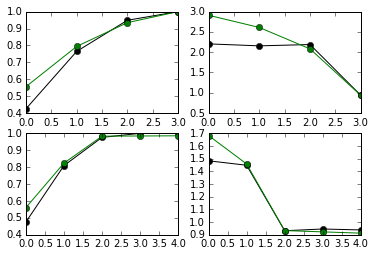

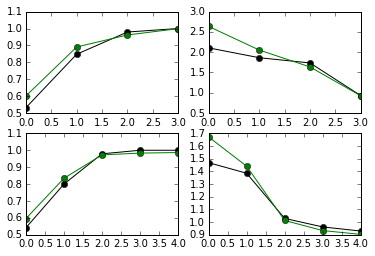

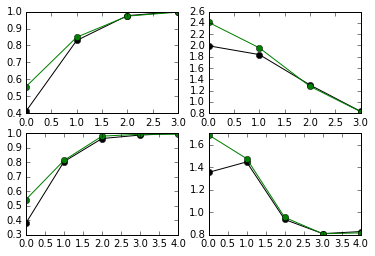

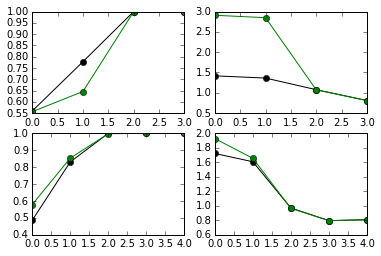

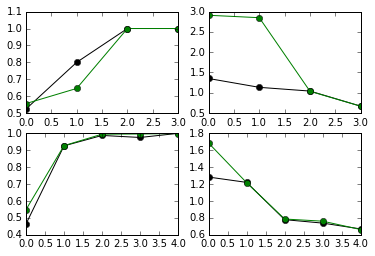

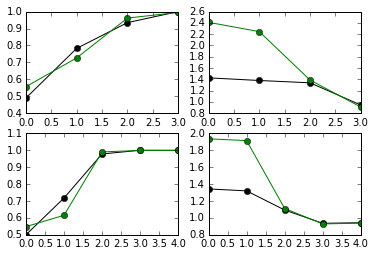

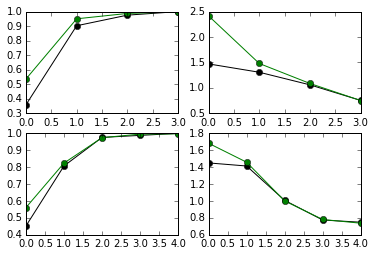

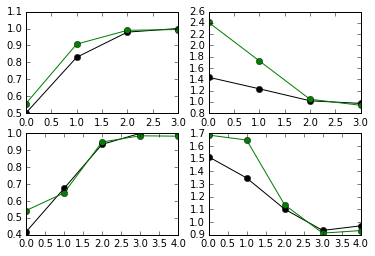

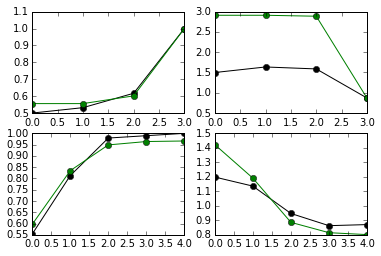

In [42]:
for si in range(nSub):
    plt.figure()
    plt.subplot(221)
    plt.plot(pCs[[4, 9, 14, 19],si], 'ko-')
    temp = []
    for ci in range(nC):
        temp.append(epc_coh[maxParId_coh[si], bestx_coh[ci,si], ci, si])
    plt.plot(temp, 'go-')

    plt.subplot(222)
    plt.plot(mRTs[[4, 9, 14, 19],si], 'ko-')
    temp = []
    for ci in range(nC):
        temp.append(ert_coh[maxParId_coh[si], bestx_coh[ci,si], ci, si])
    plt.plot(temp, 'go-')

    plt.subplot(223)
    plt.plot(pCs[[15, 16, 17, 18, 19],si], 'ko-')
    temp = []
    for di in range(nD):
        temp.append(epc_dist[maxParId_dist[si], bestx_dist[di,si], di, si])
    plt.plot(temp, 'go-')

    plt.subplot(224)
    plt.plot(mRTs[[15, 16, 17, 18, 19],si], 'ko-')
    temp = []
    for di in range(nD):
        temp.append(ert_dist[maxParId_dist[si], bestx_dist[di,si], di, si])
    plt.plot(temp, 'go-')

In [18]:
# Run 2 of the model

minA_coh = np.zeros(nSub, dtype = np.float16)
maxA_coh = np.zeros(nSub, dtype = np.float16)
mink_coh = np.zeros(nSub, dtype = np.float16)
maxk_coh = np.zeros(nSub, dtype = np.float16)
mintR_coh = np.zeros(nSub, dtype = np.float16)
maxtR_coh = np.zeros(nSub, dtype = np.float16)
minA_dist = np.zeros(nSub, dtype = np.float16)
maxA_dist = np.zeros(nSub, dtype = np.float16)
mink_dist = np.zeros(nSub, dtype = np.float16)
maxk_dist = np.zeros(nSub, dtype = np.float16)
mintR_dist = np.zeros(nSub, dtype = np.float16)
maxtR_dist = np.zeros(nSub, dtype = np.float16)

nd = 3 # Number of deltas before and after best fit value

for si in range(nSub):
    # Set up A, k and tR parameters for the next round of simulations
    # Use the bestx values from the first run, don't fit for x again
    
    # First set the range of all variables. 
    # minVar = bestValue - dVar*nd : bestValue + dVar*nd
    # If the new minimum is <= 0, then set it to the old minimum.
    minA_coh[si] = As_coh[maxParId_coh[si]] - nd * dA_coh
    maxA_coh[si] = As_coh[maxParId_coh[si]] + nd * dA_coh
    if minA_coh[si] < 0:
        minA_coh[si] = A_coh[0]
    
    mink_coh[si] = ks_coh[maxParId_coh[si]] - nd * dk_coh
    maxk_coh[si] = ks_coh[maxParId_coh[si]] + nd * dk_coh
    if mink_coh[si] < 0:
        mink_coh[si] = k_coh[0]
        
    mintR_coh[si] = tRs_coh[maxParId_coh[si]] - nd * dtR_coh
    maxtR_coh[si] = tRs_coh[maxParId_coh[si]] + nd * dtR_coh
    if mintR_coh[si] < 0:
        mintR_coh[si] = tR_coh[0]

    minA_dist[si] = As_dist[maxParId_dist[si]] - nd * dA_dist
    maxA_dist[si] = As_dist[maxParId_dist[si]] + nd * dA_dist
    if minA_dist[si] < 0:
        minA_dist[si] = A_dist[0]
    
    mink_dist[si] = ks_dist[maxParId_dist[si]] - nd * dk_dist
    maxk_dist[si] = ks_dist[maxParId_dist[si]] + nd * dk_dist
    if mink_dist[si] < 0:
        mink_dist[si] = k_dist[0]
        
    mintR_dist[si] = tRs_dist[maxParId_dist[si]] - nd * dtR_dist
    maxtR_dist[si] = tRs_dist[maxParId_dist[si]] + nd * dtR_dist
    if mintR_dist[si] < 0:
        mintR_dist[si] = tR_dist[0]

# Set up the parameter meshgrid
nStep = 9 # Number of values tested, per parameter

A_coh = np.zeros((nStep, nSub), dtype = np.float16)
dA_coh = np.zeros(nSub, dtype = np.float16)
k_coh = np.zeros((nStep, nSub), dtype = np.float16)
dk_coh = np.zeros(nSub, dtype = np.float16)
tR_coh = np.zeros((nStep, nSub), dtype = np.float16)
dtR_coh = np.zeros(nSub, dtype = np.float16)

A_dist = np.zeros((nStep, nSub), dtype = np.float16)
dA_dist = np.zeros(nSub, dtype = np.float16)
k_dist = np.zeros((nStep, nSub), dtype = np.float16)
dk_dist = np.zeros(nSub, dtype = np.float16)
tR_dist = np.zeros((nStep, nSub), dtype = np.float16)
dtR_dist = np.zeros(nSub, dtype = np.float16)

# This is the overall number of permutations of A, k and tR being performed
nPar = nStep ** 3

As_coh = np.zeros((nPar, nSub), dtype = np.float16)
ks_coh = np.zeros((nPar, nSub), dtype = np.float16)
tRs_coh = np.zeros((nPar, nSub), dtype = np.float16)

As_dist = np.zeros((nPar, nSub), dtype = np.float16)
ks_dist = np.zeros((nPar, nSub), dtype = np.float16)
tRs_dist = np.zeros((nPar, nSub), dtype = np.float16)

for si in range(nSub):
    A_coh[:,si], dA_coh[si] = np.linspace(minA_coh[si], maxA_coh[si], nStep, retstep=True)
    k_coh[:,si], dk_coh[si] = np.linspace(mink_coh[si], maxk_coh[si], nStep, retstep=True)
    tR_coh[:,si], dtR_coh[si] = np.linspace(mintR_coh[si], maxtR_coh[si], nStep, retstep=True)

    tempAs, tempks, temptRs = np.meshgrid(A_coh[:,si], k_coh[:,si], tR_coh[:,si])
    As_coh[:,si] = tempAs.flatten()
    ks_coh[:,si] = tempks.flatten()
    tRs_coh[:,si] = temptRs.flatten()
    
    A_dist[:,si], dA_dist[si] = np.linspace(minA_dist[si], maxA_dist[si], nStep, retstep=True)
    k_dist[:,si], dk_dist[si] = np.linspace(mink_dist[si], maxk_dist[si], nStep, retstep=True)
    tR_dist[:,si], dtR_dist[si] = np.linspace(mintR_dist[si], maxtR_dist[si], nStep, retstep=True)

    tempAs, tempks, temptRs = np.meshgrid(A_dist[:,si], k_dist[:,si], tR_dist[:,si])
    As_dist[:,si] = tempAs.flatten()
    ks_dist[:,si] = tempks.flatten()
    tRs_dist[:,si] = temptRs.flatten()
    
    # Initialize arrays that hold predicted accuracies and RTs
    epc_coh = np.ones((nPar, nC, nSub)) * -9
    ert_coh = np.ones((nPar, nC, nSub)) * -9
    sdrt_coh = np.ones((nPar, nC, nSub)) * -9
    epc_dist = np.ones((nPar, nD, nSub)) * -9
    ert_dist = np.ones((nPar, nD, nSub)) * -9
    sdrt_dist = np.ones((nPar, nD, nSub)) * -9

    ## Initialize the array that holds the
    # individual likelihood values
    lpc_coh = np.zeros((nPar, nC, nSub))
    lrt_coh = np.zeros((nPar, nC, nSub))
    lpc_dist = np.zeros((nPar, nD, nSub))
    lrt_dist = np.zeros((nPar, nD, nSub))
    
# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
for si in range(nSub):
    for pi in xrange(nPar):
        for ci in range(nC):
            # Calculate expected accuracy for each coherence-distance combination
            epc_coh[pi,ci,si] = 1 / (1 + np.exp(-2 * As_coh[pi,si] * ks_coh[pi,si] * abs(x_coh[bestx_coh[ci,si]])))

            # Calculate likelihood of accuracy for this CD combination
            lpc_coh[pi,ci,si] = fact(Ns[(ci+1)*5-1,si]) / (fact(Rs[(ci+1)*5-1,si]) * fact(Ns[(ci+1)*5-1,si]-Rs[(ci+1)*5-1,si])) \
                                * (epc_coh[pi,ci,si] ** Rs[(ci+1)*5-1,si]) * \
                                ((1 - epc_coh[pi,ci,si]) ** (Ns[(ci+1)*5-1,si] - Rs[(ci+1)*5-1,si]))
            
            # Calculate expected mean RT for each coherence-distance combination
            ert_coh[pi,ci,si] = As_coh[pi,si] / (ks_coh[pi,si] * x_coh[bestx_coh[ci,si]]) * \
                                np.tanh(As_coh[pi,si] * ks_coh[pi,si] * x_coh[bestx_coh[ci,si]]) + tRs_coh[pi,si] 
            # Calculate SD of mean RT 
            sdrt_coh[pi,ci,si] = np.sqrt(((As_coh[pi,si] * np.tanh(As_coh[pi,si] * ks_coh[pi,si] * x_coh[bestx_coh[ci,si]]) - \
                    As_coh[pi,si] * ks_coh[pi,si] * x_coh[bestx_coh[ci,si]] * \
                    (1/np.cosh(np.square(As_coh[pi,si] * ks_coh[pi,si] * x_coh[bestx_coh[ci,si]])))) / \
                    (ks_coh[pi,si] * x_coh[bestx_coh[ci,si]]) ** 3 + np.square(0.1 * tRs_coh[pi,si])) / Ns[(ci+1)*5-1,si])
            # Calculate likelihood of mean RT for this CD combination
            lrt_coh[pi,ci,si] = 1 / (sdrt_coh[pi,ci,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert_coh[pi,ci,si] - mRTs[(ci+1)*5-1,si]) / sdrt_coh[pi,ci,si]))

for si in range(nSub):
    for pi in xrange(nPar):
        for di in range(nD):
            # Calculate expected accuracy for each coherence-distance combination
            epc_dist[pi,di,si] = 1 / (1 + np.exp(-2 * As_dist[pi,si] * ks_dist[pi,si] * abs(x_dist[bestx_dist[di,si]])))

            # Calculate likelihood of accuracy for this CD combination
            lpc_dist[pi,di,si] = fact(Ns[di+15,si]) / (fact(Rs[di+15,si]) * fact(Ns[di+15,si]-Rs[di+15,si])) * \
                                (epc_dist[pi,di,si] ** Rs[di+15,si]) * \
                                ((1 - epc_dist[pi,di,si]) ** (Ns[di+15,si] - Rs[di+15,si]))
            
            # Calculate expected mean RT for each coherence-distance combination
            ert_dist[pi,di,si] = As_dist[pi,si] / (ks_dist[pi,si] * x_dist[bestx_dist[di,si]]) * \
                                np.tanh(As_dist[pi,si] * ks_dist[pi,si] * x_dist[bestx_dist[di,si]]) + tRs_dist[pi,si] 
            # Calculate SD of mean RT 
            sdrt_dist[pi,di,si] = np.sqrt(((As_dist[pi,si] * np.tanh(As_dist[pi,si] * ks_dist[pi,si] * x_dist[bestx_dist[di,si]]) \
                    - As_dist[pi,si] * ks_dist[pi,si] * x_dist[bestx_dist[di,si]] * \
                    (1/np.cosh(np.square(As_dist[pi,si] * ks_dist[pi,si] * x_dist[bestx_dist[di,si]])))) / \
                    (ks_dist[pi,si] * x_dist[bestx_dist[di,si]]) ** 3 + np.square(0.1 * tRs_dist[pi,si])) / Ns[di+15,si])
            # Calculate likelihood of mean RT for this CD combination
            lrt_dist[pi,di,si] = 1 / (sdrt_dist[pi,di,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert_dist[pi,di,si] - mRTs[di+15,si]) / sdrt_dist[pi,di,si]))

                
# Calculate the total log-likelihood for each parameter combination
totLL_coh = np.zeros((nPar, nSub))
totLL_dist = np.zeros((nPar, nSub))
for si in range(nSub):
    for pi in range(nPar):
        for ci in range(nC):
            totLL_coh[pi,si] += np.log(lpc_coh[pi,ci,si]) + np.log(lrt_coh[pi,ci,si])
            
        for di in range(nD):
            totLL_dist[pi,si] += np.log(lpc_dist[pi,di,si]) + np.log(lrt_dist[pi,di,si])

# Find the parameters for which likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId_coh = np.zeros(nSub, dtype = np.int)
maxParId_dist = np.zeros(nSub, dtype = np.int)
for si in range(nSub):
    maxParId_coh[si] = np.where(totLL_coh[:,si] == np.nanmax(totLL_coh[:,si]))[0]
    maxParId_dist[si] = np.where(totLL_dist[:,si] == np.nanmax(totLL_dist[:,si]))[0]

In [19]:
temp = 0
sumLL = []
for si in range(nSub):
    temp += totLL_coh[maxParId_coh[si],si] + totLL_dist[maxParId_dist[si],si]
sumLL.append(temp)

In [ ]:
for si in range(nSub):
    plt.figure()
    plt.subplot(221)
    plt.plot(pCs[[4, 9, 14, 19],si], 'ko-')
    temp = []
    for ci in range(nC):
        temp.append(epc_coh[maxParId_coh[si], ci, si])
    plt.plot(temp, 'go-')

    plt.subplot(222)
    plt.plot(mRTs[[4, 9, 14, 19],si], 'ko-')
    temp = []
    for ci in range(nC):
        temp.append(ert_coh[maxParId_coh[si], ci, si])
    plt.plot(temp, 'go-')

    plt.subplot(223)
    plt.plot(pCs[[15, 16, 17, 18, 19],si], 'ko-')
    temp = []
    for di in range(nD):
        temp.append(epc_dist[maxParId_dist[si], di, si])
    plt.plot(temp, 'go-')

    plt.subplot(224)
    plt.plot(mRTs[[15, 16, 17, 18, 19],si], 'ko-')
    temp = []
    for di in range(nD):
        temp.append(ert_dist[maxParId_dist[si], di, si])
    plt.plot(temp, 'go-')

In [20]:
run = 3
# This variable keeps track of whether the simulation should continue or not
simStop = 0

while simStop == 0:
    minA_coh = np.zeros(nSub, dtype = np.float16)
    maxA_coh = np.zeros(nSub, dtype = np.float16)
    mink_coh = np.zeros(nSub, dtype = np.float16)
    maxk_coh = np.zeros(nSub, dtype = np.float16)
    mintR_coh = np.zeros(nSub, dtype = np.float16)
    maxtR_coh = np.zeros(nSub, dtype = np.float16)
    minA_dist = np.zeros(nSub, dtype = np.float16)
    maxA_dist = np.zeros(nSub, dtype = np.float16)
    mink_dist = np.zeros(nSub, dtype = np.float16)
    maxk_dist = np.zeros(nSub, dtype = np.float16)
    mintR_dist = np.zeros(nSub, dtype = np.float16)
    maxtR_dist = np.zeros(nSub, dtype = np.float16)

    for si in range(nSub):
        # Set up A, k and tR parameters for the next round of simulations
        # Use the bestx values from the first run, don't fit for x again

        # First set the range of all variables. 
        # minVar = bestValue - dVar*nd : bestValue + dVar*nd
        # If the new minimum is <= 0, then set it to the old minimum.
        minA_coh[si] = As_coh[maxParId_coh[si],si] - nd * dA_coh[si]
        maxA_coh[si] = As_coh[maxParId_coh[si],si] + nd * dA_coh[si]
        if minA_coh[si] < 0:
            minA_coh[si] = A_coh[0,si]

        mink_coh[si] = ks_coh[maxParId_coh[si],si] - nd * dk_coh[si]
        maxk_coh[si] = ks_coh[maxParId_coh[si],si] + nd * dk_coh[si]
        if mink_coh[si] < 0:
            mink_coh[si] = k_coh[0,si]

        mintR_coh[si] = tRs_coh[maxParId_coh[si],si] - nd * dtR_coh[si]
        maxtR_coh[si] = tRs_coh[maxParId_coh[si],si] + nd * dtR_coh[si]
        if mintR_coh[si] < 0:
            mintR_coh[si] = tR_coh[0,si]

        minA_dist[si] = As_dist[maxParId_dist[si],si] - nd * dA_dist[si]
        maxA_dist[si] = As_dist[maxParId_dist[si],si] + nd * dA_dist[si]
        if minA_dist[si] < 0:
            minA_dist[si] = A_dist[0,si]

        mink_dist[si] = ks_dist[maxParId_dist[si],si] - nd * dk_dist[si]
        maxk_dist[si] = ks_dist[maxParId_dist[si],si] + nd * dk_dist[si]
        if mink_dist[si] < 0:
            mink_dist[si] = k_dist[0,si]

        mintR_dist[si] = tRs_dist[maxParId_dist[si],si] - nd * dtR_dist[si]
        maxtR_dist[si] = tRs_dist[maxParId_dist[si],si] + nd * dtR_dist[si]
        if mintR_dist[si] < 0:
            mintR_dist[si] = tR_dist[0,si]

    # Set up the parameter meshgrid
    
    A_coh = np.zeros((nStep, nSub), dtype = np.float16)
    dA_coh = np.zeros(nSub, dtype = np.float16)
    k_coh = np.zeros((nStep, nSub), dtype = np.float16)
    dk_coh = np.zeros(nSub, dtype = np.float16)
    tR_coh = np.zeros((nStep, nSub), dtype = np.float16)
    dtR_coh = np.zeros(nSub, dtype = np.float16)

    A_dist = np.zeros((nStep, nSub), dtype = np.float16)
    dA_dist = np.zeros(nSub, dtype = np.float16)
    k_dist = np.zeros((nStep, nSub), dtype = np.float16)
    dk_dist = np.zeros(nSub, dtype = np.float16)
    tR_dist = np.zeros((nStep, nSub), dtype = np.float16)
    dtR_dist = np.zeros(nSub, dtype = np.float16)

    # This is the overall number of permutations of A, k and tR being performed
    nPar = nStep ** 3

    As_coh = np.zeros((nPar, nSub), dtype = np.float16)
    ks_coh = np.zeros((nPar, nSub), dtype = np.float16)
    tRs_coh = np.zeros((nPar, nSub), dtype = np.float16)

    As_dist = np.zeros((nPar, nSub), dtype = np.float16)
    ks_dist = np.zeros((nPar, nSub), dtype = np.float16)
    tRs_dist = np.zeros((nPar, nSub), dtype = np.float16)

    for si in range(nSub):
        A_coh[:,si], dA_coh[si] = np.linspace(minA_coh[si], maxA_coh[si], nStep, retstep=True)
        k_coh[:,si], dk_coh[si] = np.linspace(mink_coh[si], maxk_coh[si], nStep, retstep=True)
        tR_coh[:,si], dtR_coh[si] = np.linspace(mintR_coh[si], maxtR_coh[si], nStep, retstep=True)

        tempAs, tempks, temptRs = np.meshgrid(A_coh[:,si], k_coh[:,si], tR_coh[:,si])
        As_coh[:,si] = tempAs.flatten()
        ks_coh[:,si] = tempks.flatten()
        tRs_coh[:,si] = temptRs.flatten()

        A_dist[:,si], dA_dist[si] = np.linspace(minA_dist[si], maxA_dist[si], nStep, retstep=True)
        k_dist[:,si], dk_dist[si] = np.linspace(mink_dist[si], maxk_dist[si], nStep, retstep=True)
        tR_dist[:,si], dtR_dist[si] = np.linspace(mintR_dist[si], maxtR_dist[si], nStep, retstep=True)

        tempAs, tempks, temptRs = np.meshgrid(A_dist[:,si], k_dist[:,si], tR_dist[:,si])
        As_dist[:,si] = tempAs.flatten()
        ks_dist[:,si] = tempks.flatten()
        tRs_dist[:,si] = temptRs.flatten()

        # Initialize arrays that hold predicted accuracies and RTs
        epc_coh = np.ones((nPar, nC, nSub)) * -9
        ert_coh = np.ones((nPar, nC, nSub)) * -9
        sdrt_coh = np.ones((nPar, nC, nSub)) * -9
        epc_dist = np.ones((nPar, nD, nSub)) * -9
        ert_dist = np.ones((nPar, nD, nSub)) * -9
        sdrt_dist = np.ones((nPar, nD, nSub)) * -9

        ## Initialize the array that holds the
        # individual likelihood values
        lpc_coh = np.zeros((nPar, nC, nSub))
        lrt_coh = np.zeros((nPar, nC, nSub))
        lpc_dist = np.zeros((nPar, nD, nSub))
        lrt_dist = np.zeros((nPar, nD, nSub))

    
    # From the set of parameters, calculate the (expected) predicted PC and RT
    # and then find the likelihood that these estimates match the observed PC and RT
    for si in range(nSub):
        for pi in xrange(nPar):
            for ci in range(nC):
                # Calculate expected accuracy for each coherence-distance combination
                epc_coh[pi,ci,si] = 1 / (1 + np.exp(-2 * As_coh[pi,si] * ks_coh[pi,si] * abs(x_coh[bestx_coh[ci,si]])))

                # Calculate likelihood of accuracy for this CD combination
                lpc_coh[pi,ci,si] = fact(Ns[(ci+1)*5-1,si]) / (fact(Rs[(ci+1)*5-1,si]) * fact(Ns[(ci+1)*5-1,si]-Rs[(ci+1)*5-1,si])) \
                                    * (epc_coh[pi,ci,si] ** Rs[(ci+1)*5-1,si]) * \
                                    ((1 - epc_coh[pi,ci,si]) ** (Ns[(ci+1)*5-1,si] - Rs[(ci+1)*5-1,si]))
                
                # Calculate expected mean RT for each coherence-distance combination
                ert_coh[pi,ci,si] = As_coh[pi,si] / (ks_coh[pi,si] * x_coh[bestx_coh[ci,si]]) * \
                                    np.tanh(As_coh[pi,si] * ks_coh[pi,si] * x_coh[bestx_coh[ci,si]]) + tRs_coh[pi,si] 
                # Calculate SD of mean RT 
                sdrt_coh[pi,ci,si] = np.sqrt(((As_coh[pi,si] * np.tanh(As_coh[pi,si] * ks_coh[pi,si] * x_coh[bestx_coh[ci,si]]) - \
                        As_coh[pi,si] * ks_coh[pi,si] * x_coh[bestx_coh[ci,si]] * \
                        (1/np.cosh(np.square(As_coh[pi,si] * ks_coh[pi,si] * x_coh[bestx_coh[ci,si]])))) / \
                        (ks_coh[pi,si] * x_coh[bestx_coh[ci,si]]) ** 3 + np.square(0.1 * tRs_coh[pi,si])) / Ns[(ci+1)*5-1,si])
                # Calculate likelihood of mean RT for this CD combination
                lrt_coh[pi,ci,si] = 1 / (sdrt_coh[pi,ci,si] * np.sqrt(2 * np.pi)) * \
                                    np.e ** (-1/2 * np.square((ert_coh[pi,ci,si] - mRTs[(ci+1)*5-1,si]) / sdrt_coh[pi,ci,si]))

    for si in range(nSub):
        for pi in xrange(nPar):
            for di in range(nD):
                # Calculate expected accuracy for each coherence-distance combination
                epc_dist[pi,di,si] = 1 / (1 + np.exp(-2 * As_dist[pi,si] * ks_dist[pi,si] * abs(x_dist[bestx_dist[di,si]])))

                # Calculate likelihood of accuracy for this CD combination
                lpc_dist[pi,di,si] = fact(Ns[di+15,si]) / (fact(Rs[di+15,si]) * fact(Ns[di+15,si]-Rs[di+15,si])) * \
                                    (epc_dist[pi,di,si] ** Rs[di+15,si]) * \
                                    ((1 - epc_dist[pi,di,si]) ** (Ns[di+15,si] - Rs[di+15,si]))

                # Calculate expected mean RT for each coherence-distance combination
                ert_dist[pi,di,si] = As_dist[pi,si] / (ks_dist[pi,si] * x_dist[bestx_dist[di,si]]) * \
                                    np.tanh(As_dist[pi,si] * ks_dist[pi,si] * x_dist[bestx_dist[di,si]]) + tRs_dist[pi,si] 
                # Calculate SD of mean RT 
                sdrt_dist[pi,di,si] = np.sqrt(((As_dist[pi,si] * np.tanh(As_dist[pi,si] * ks_dist[pi,si] * x_dist[bestx_dist[di,si]]) \
                        - As_dist[pi,si] * ks_dist[pi,si] * x_dist[bestx_dist[di,si]] * \
                        (1/np.cosh(np.square(As_dist[pi,si] * ks_dist[pi,si] * x_dist[bestx_dist[di,si]])))) / \
                        (ks_dist[pi,si] * x_dist[bestx_dist[di,si]]) ** 3 + np.square(0.1 * tRs_dist[pi,si])) / Ns[di+15,si])
                # Calculate likelihood of mean RT for this CD combination
                lrt_dist[pi,di,si] = 1 / (sdrt_dist[pi,di,si] * np.sqrt(2 * np.pi)) * \
                                    np.e ** (-1/2 * np.square((ert_dist[pi,di,si] - mRTs[di+15,si]) / sdrt_dist[pi,di,si]))
                    
    
    # Calculate the total log-likelihood for each parameter combination
    totLL_coh = np.zeros((nPar, nSub))
    totLL_dist = np.zeros((nPar, nSub))
    for si in range(nSub):
        for pi in range(nPar):
            for ci in range(nC):
                totLL_coh[pi,si] += np.log(lpc_coh[pi,ci,si]) + np.log(lrt_coh[pi,ci,si])

            for di in range(nD):
                totLL_dist[pi,si] += np.log(lpc_dist[pi,di,si]) + np.log(lrt_dist[pi,di,si])

    # Find the parameters for which likelihood is maximum
    # There are some NaN values in the likelihood matrix so exclude those
    maxParId_coh = np.zeros(nSub, dtype = np.int)
    maxParId_dist = np.zeros(nSub, dtype = np.int)
    for si in range(nSub):
        ids = np.where(totLL_coh[:,si] == np.nanmax(totLL_coh[:,si]))[0]
        if len(ids) > 1:
            maxParId_coh[si] = ids[0]
        else: 
            maxParId_coh[si] = ids
            
        ids = np.where(totLL_dist[:,si] == np.nanmax(totLL_dist[:,si]))[0]
        if len(ids) > 1:
            maxParId_dist[si] = ids[0]
        else:
            maxParId_dist[si] = ids
    
    # Calculate total maximum loglikelihoods
    temp = 0
    for si in range(nSub):
        temp += totLL_coh[maxParId_coh[si],si] + totLL_dist[maxParId_dist[si],si]
   
    # Check to see if the simulation should continue for another run
    if abs(sumLL[-1] - temp) < 1:
        simStop = 1
    else:
        sumLL.append(temp)
    
    run += 1

In [21]:
run

11

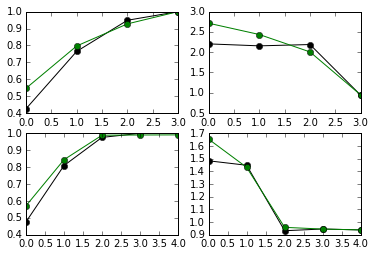

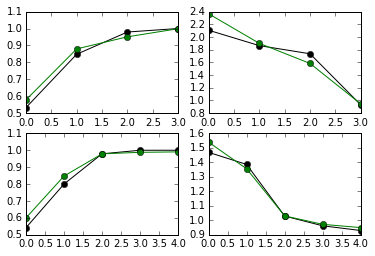

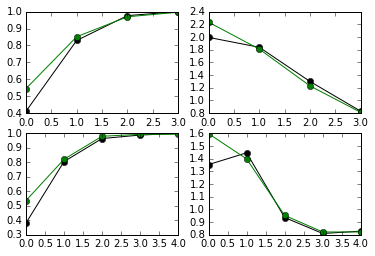

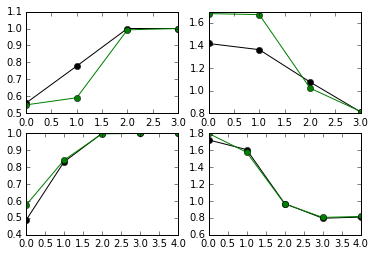

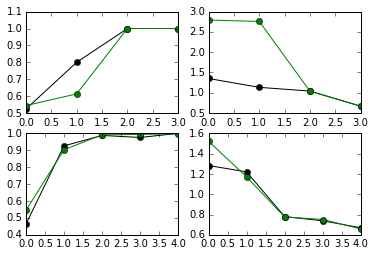

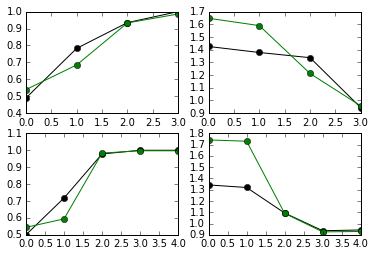

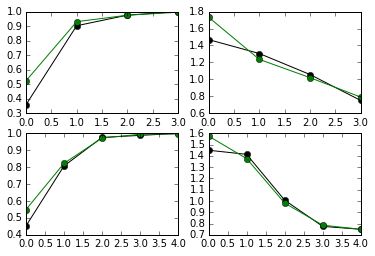

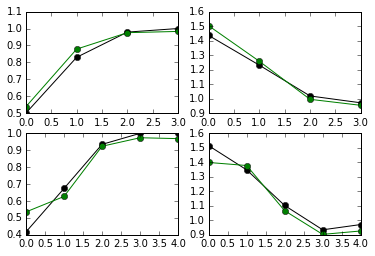

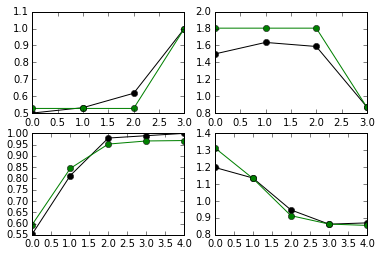

In [22]:
for si in range(nSub):
    plt.figure()
    plt.subplot(221)
    plt.plot(pCs[[4, 9, 14, 19],si], 'ko-')
    temp = []
    for ci in range(nC):
        temp.append(epc_coh[maxParId_coh[si], ci, si])
    plt.plot(temp, 'go-')

    plt.subplot(222)
    plt.plot(mRTs[[4, 9, 14, 19],si], 'ko-')
    temp = []
    for ci in range(nC):
        temp.append(ert_coh[maxParId_coh[si], ci, si])
    plt.plot(temp, 'go-')

    plt.subplot(223)
    plt.plot(pCs[[15, 16, 17, 18, 19],si], 'ko-')
    temp = []
    for di in range(nD):
        temp.append(epc_dist[maxParId_dist[si], di, si])
    plt.plot(temp, 'go-')

    plt.subplot(224)
    plt.plot(mRTs[[15, 16, 17, 18, 19],si], 'ko-')
    temp = []
    for di in range(nD):
        temp.append(ert_dist[maxParId_dist[si], di, si])
    plt.plot(temp, 'go-')

In [23]:
for si in range(nSub):
    print(round(As_coh[maxParId_coh[si],si],ndigits=2),round(ks_coh[maxParId_coh[si],si],ndigits=2),\
          round(tRs_coh[maxParId_coh[si],si],ndigits=2))
    
print()
for si in range(nSub):
    print(round(As_dist[maxParId_dist[si],si],ndigits=2),round(ks_dist[maxParId_dist[si],si],ndigits=2),\
          round(tRs_dist[maxParId_dist[si],si],ndigits=2))

1.47 1.25 0.55
1.43 1.21 0.34
1.49 1.19 0.02
1.06 1.01 0.57
1.52 1.17 0.5
1.13 1.37 0.37
1.22 3.66 0.25
1.03 1.47 0.45
1.03 5.32 0.75

1.12 1.42 0.42
1.02 1.52 0.51
1.13 1.27 0.32
1.13 1.21 0.53
1.13 1.13 0.25
1.12 1.13 0.5
1.13 1.23 0.3
1.02 2.29 0.36
1.02 1.45 0.28


In [49]:
# Now that I have the best fit x, A, tR for all subjects, I'll continue to use them
# for the other coherences and distances while fitting k values afresh.

# First, assign the best A, tR and x values for each subject
Afin_coh = np.zeros(nSub)
tRfin_coh = np.zeros(nSub)
xfin_coh = np.zeros((nC,nSub))

Afin_dist = np.zeros(nSub)
tRfin_dist = np.zeros(nSub)
xfin_dist = np.zeros((nD,nSub))

for si in range(nSub):
    Afin_coh[si] = As_coh[maxParId_coh[si],si]
    tRfin_coh[si] = tRs_coh[maxParId_coh[si],si]
    xfin_coh[:,si] = x_coh[bestx_coh[:,si]]
    
    Afin_dist[si] = As_dist[maxParId_dist[si],si]
    tRfin_dist[si] = tRs_dist[maxParId_dist[si],si]
    xfin_dist[:,si] = x_dist[bestx_dist[:,si]]
    
# Initialize k values for coherence and distance
k_coh, dk_coh = np.linspace(0.1, 10, 10, retstep=True)
k_dist, dk_dist = np.linspace(0.1, 10, 10, retstep=True)
nK = len(k_coh)

# Initialize arrays that hold predicted accuracies and RTs
epc_coh_d = np.ones((nK, nD-1, nC, nSub)) * -9
ert_coh_d = np.ones((nK, nD-1, nC, nSub)) * -9
sdrt_coh_d = np.ones((nK, nD-1, nC, nSub)) * -9
epc_dist_c = np.ones((nK, nC-1, nD, nSub)) * -9
ert_dist_c = np.ones((nK, nC-1, nD, nSub)) * -9
sdrt_dist_c = np.ones((nK, nC-1, nD, nSub)) * -9

## Initialize the array that holds the
# individual likelihood values
lpc_coh_d = np.zeros((nK, nD-1, nC, nSub))
lrt_coh_d = np.zeros((nK, nD-1, nC, nSub))
lpc_dist_c = np.zeros((nK, nC-1, nD, nSub))
lrt_dist_c = np.zeros((nK, nC-1, nD, nSub))


In [50]:
## Now find the set of ks for 
# - All coherences at the different distances

# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
# for all coherences at each distance
for si in range(nSub):
    for ki in range(nK):
        for di in range(nD-1):
            for ci in range(nC):
                # Calculate expected accuracy for each coherence-distance combination
                epc_coh_d[ki,di,ci,si] = 1 / (1 + np.exp(-2 * Afin_coh[si] * k_coh[ki] * abs(xfin_coh[ci,si])))

                # Calculate likelihood of accuracy for this CD combination
                lpc_coh_d[ki,di,ci,si] = fact(Ns[ci*5+di,si]) / (fact(Rs[ci*5+di,si]) * \
                                                                  fact(Ns[ci*5+di,si]-Rs[ci*5+di,si])) \
                                    * (epc_coh_d[ki,di,ci,si] ** Rs[ci*5+di,si]) * \
                                    ((1 - epc_coh_d[ki,di,ci,si]) ** (Ns[ci*5+di,si] - Rs[ci*5+di,si]))
                
                # Calculate expected mean RT for each coherence-distance combination
                ert_coh_d[ki,di,ci,si] = Afin_coh[si] / (k_coh[ki] * xfin_coh[ci,si]) * \
                                    np.tanh(Afin_coh[si] * k_coh[ki] * xfin_coh[ci,si]) + tRfin_coh[si] 
                # Calculate SD of mean RT 
                sdrt_coh_d[ki,di,ci,si] = np.sqrt(((Afin_coh[si] * np.tanh(Afin_coh[si] * k_coh[ki] * xfin_coh[ci,si]) - \
                        Afin_coh[si] * k_coh[ki] * xfin_coh[ci,si] * \
                        (1/np.cosh(np.square(Afin_coh[si] * k_coh[ki] * xfin_coh[ci,si])))) / \
                        (k_coh[ki] * xfin_coh[ci,si]) ** 3 + np.square(0.1 * tRfin_coh[si])) / Ns[ci*5+di,si])
                # Calculate likelihood of mean RT for this CD combination
                lrt_coh_d[ki,di,ci,si] = 1 / (sdrt_coh_d[ki,di,ci,si] * np.sqrt(2 * np.pi)) * \
                                    np.e ** (-1/2 * np.square((ert_coh_d[ki,di,ci,si] - mRTs[ci*5+di,si]) / \
                                                              sdrt_coh_d[ki,di,ci,si]))

In [ ]:
# Calculate the total log-likelihood for each parameter combination
totLL_coh_d = np.zeros((nK, nD-1, nSub))
for si in range(nSub):
    for ki in range(nK):
        for di in range(nD-1):
            for ci in range(nC):
                totLL_coh_d[ki,di,si] += np.log(lpc_coh[pi,ci,si]) + np.log(lrt_coh[pi,ci,si])


# Find the parameters for which likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId_coh_d = np.zeros((nD-1, nSub), dtype = np.int)

for si in range(nSub):
    for di in range(nD-1):
        ids = np.where(totLL_coh_d[:,di,si] == np.nanmax(totLL_coh_d[:,di,si]))[0]
        if len(ids) > 1:
            maxParId_coh_d[di,si] = ids[0]
        else: 
            maxParId_coh_d[di,si] = ids 

In [51]:
## Now find the set of ks for 
# - All distances at the different coherences

# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
# for all distances at each coherence
for si in range(nSub):
    for ki in range(nK):
        for ci in range(nC-1):
            for di in range(nD):
                # Calculate expected accuracy for each coherence-distance combination
                epc_dist_c[ki,ci,di,si] = 1 / (1 + np.exp(-2 * Afin_dist[si] * k_dist[ki] * abs(xfin_dist[di,si])))

                # Calculate likelihood of accuracy for this CD combination
                lpc_dist_c[ki,ci,di,si] = fact(Ns[ci*5+di,si]) / (fact(Rs[ci*5+di,si]) * \
                                                                  fact(Ns[ci*5+di,si]-Rs[ci*5+di,si])) \
                                    * (epc_dist_c[ki,ci,di,si] ** Rs[ci*5+di,si]) * \
                                    ((1 - epc_dist_c[ki,ci,di,si]) ** (Ns[ci*5+di,si] - Rs[ci*5+di,si]))
                
                # Calculate expected mean RT for each coherence-distance combination
                ert_dist_c[ki,ci,di,si] = Afin_dist[si] / (k_dist[ki] * xfin_dist[di,si]) * \
                                    np.tanh(Afin_dist[si] * k_dist[ki] * xfin_dist[di,si]) + tRfin_dist[si] 
                # Calculate SD of mean RT 
                sdrt_dist_c[ki,ci,di,si] = np.sqrt(((Afin_dist[si] * np.tanh(Afin_dist[si] * k_dist[ki] * xfin_dist[di,si]) - \
                        Afin_dist[si] * k_dist[ki] * xfin_dist[di,si] * \
                        (1/np.cosh(np.square(Afin_dist[si] * k_dist[ki] * xfin_dist[di,si])))) / \
                        (k_dist[ki] * xfin_dist[di,si]) ** 3 + np.square(0.1 * tRfin_dist[si])) / Ns[ci*5+di,si])
                # Calculate likelihood of mean RT for this CD combination
                lrt_dist_c[ki,ci,di,si] = 1 / (sdrt_dist_c[ki,ci,di,si] * np.sqrt(2 * np.pi)) * \
                                    np.e ** (-1/2 * np.square((ert_dist_c[ki,ci,di,si] - mRTs[ci*5+di,si]) / \
                                                              sdrt_dist_c[ki,ci,di,si]))

In [ ]:
# Calculate the total log-likelihood for each parameter combination
totLL_dist_c = np.zeros((nK, nC-1, nSub))
for si in range(nSub):
    for ki in range(nK):
        for ci in range(nC-1):
            for di in range(nD):
                totLL_dist_c[ki,ci,si] += np.log(lpc_dist[pi,di,si]) + np.log(lrt_dist[pi,di,si])
                
# Find the parameters for which likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId_dist_c = np.zeros((nC-1, nSub), dtype = np.int)

for si in range(nSub):
    for ci in range(nC-1):
        ids = np.where(totLL_dist_c[:,ci,si] == np.nanmax(totLL_dist_c[:,ci,si]))[0]
        if len(ids) > 1:
            maxParId_dist_c[ci,si] = ids[0]
        else:
            maxParId_dist_c[ci,si] = ids